Import

In [1]:
import torch
import seaborn as sns
from ultralytics import YOLO
import cv2
from sort.sort import *
from deep_sort.deep_sort import nn_matching
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.detection import Detection
from deep_sort_realtime.deepsort_tracker import DeepSort
import pandas as pd
import matplotlib.pyplot as plt
import math
from torchvision.utils import draw_bounding_boxes
import torchvision
from classify_by_movement import *
import pandas as pd
from calculate_features import *

In [2]:
# Show graph inline
%matplotlib inline

Load model for object detection

In [3]:
# Load the YOLOv5 model from the checkpoint
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best_yolov5x.pt')

Using cache found in C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-2-20 Python-3.11.7 torch-2.6.0+cpu CPU

Fusing layers... 
Model summary: 444 layers, 86186872 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


Show results of image

In [ ]:
# Run inference on an image
img = '../data_orig/val/12/images/12_frame_0.jpg'  # Replace with your image path

results = model(img)

# Show the results
results.show()  # Displays the image with bounding boxes

# Save the results
results.save('output/')  # Saves the output image with bounding boxes


KeyboardInterrupt



## Show results of video

In [25]:
# Open the video file
video_number = str(11)
fps = 50  # Replace with your video's frame rate

video_path = '../data/VISEM_Tracking/train/'+video_number+'/'+video_number+'.mp4'

###### Show video in 50 fps

In [ ]:
cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    ret, frame = cap.read()
    # Wait for a key press (25ms delay between frames)
    # Press 'q' to exit the sequence
    cv2.imshow('YOLOv5 Inference', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

##### Object detection

In [28]:
cap = cv2.VideoCapture(video_path)
metric = nn_matching.NearestNeighborDistanceMetric("cosine",0.1)
tracker = Sort(max_age=50, min_hits=20, iou_threshold=0.1) 
tracking_data = []
trajectories = {}
frame_id = 0
# Process the video frame by frame
while cap.isOpened():
    print("Frame_id:", frame_id)
    ret, frame = cap.read()
    if not ret:
        break

    # Run inference on the frame
    results = model(frame)
    
    # Extract bounding box information
    bbox_data = results.pandas().xyxy[0]
    detections = bbox_data[['xmin', 'ymin', 'xmax', 'ymax', 'confidence']].values

    '''
     # Prepare detections for Deep SORT
    deepsort_detections = []
    for detection in bbox_data:
        x1, y1, x2, y2, conf, cls = detection
        bbox = [x1, y1, x2 - x1, y2 - y1]  # Convert to [x, y, w, h]
        deepsort_detections.append(Detection(bbox, conf, cls))
    
    '''

    labels = results.pandas().xyxy[0]['class'].values

    # Update the tracker with the detected bounding boxes
    tracks = tracker.update(detections)
    
    '''
    # Draw bounding boxes and track IDs on the frame
    for track in tracks:
        xmin, ymin, xmax, ymax, track_id = track
        xmin, ymin, xmax, ymax, track_id = map(int, [xmin, ymin, xmax, ymax, track_id])

        # Draw bounding box
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Draw track ID
        cv2.putText(frame, f"ID: {track_id}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    '''

    # Inside the frame processing loop:
    for idx,track in enumerate(tracks):
        xmin, ymin, xmax, ymax, track_id = track
        cx, cy = (xmin + xmax) / 2, (ymin + ymax) / 2  # Centroid
        tracking_data.append([frame_id, track_id, labels[idx], cx, cy, xmin, ymin, xmax, ymax])
        
        if track_id not in trajectories:
            trajectories[track_id] = []
        trajectories[track_id].append((cx, cy))
        
        # Draw path
        for i in range(1, len(trajectories[track_id])):
            cv2.line(frame, (int(trajectories[track_id][i - 1][0]),int(trajectories[track_id][i - 1][1])), (int(trajectories[track_id][i][0]),int(trajectories[track_id][i][1])), (0, 255, 0), 2) 

    # Render the results on the frame
    #rendered_frame = results.render()[0]
    # Display the frame
    cv2.imshow('YOLOv5 Inference', frame)

    # Wait for a key press (25ms delay between frames)
    # Press 'q' to exit the sequence
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    frame_id += 1

# Release the video capture object and close windows
cap.release()
cv2.destroyAllWindows()

# Save tracking data to a CSV file
df = pd.DataFrame(tracking_data, columns=['frame_id', 'track_id', 'class', 'cx', 'cy', 'xmin', 'ymin', 'xmax', 'ymax'])
df.to_csv('results/data_sperm_tracking/sperm_tracking_data_' + video_number + '.csv', index=False)

Frame_id: 0


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 1


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 2


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 3


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 4


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 5


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 6


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 7


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 8


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 9


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 10


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 11


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 12


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 13


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 14


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 15


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 16


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 17


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 18


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 19


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 20


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 21


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 22


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 23


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 24


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 25


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 26


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame_id: 27


C:\Users\Sergio/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


OSError: Cannot save file into a non-existent directory: 'results\data_sperm_tracking'

## Calculate centroid

In [ ]:
# Load the tracking data from a CSV file
df = pd.read_csv('results/data_sperm_tracking/sperm_tracking_data_'+video_number+'.csv')

# Calculate velocity for each track_id
df['velocity_x'] = 0.0
df['velocity_y'] = 0.0
df['speed'] = 0.0

# Frame rate of the video (frames per second)
dt = 1 / fps  # Time interval between frames

# Group by track_id and calculate velocity
for track_id, group in df.groupby('track_id'):
    # Calculate displacement (delta x and delta y)
    group['delta_x'] = group['cx'].diff()
    group['delta_y'] = group['cy'].diff()

    # Calculate velocity (pixels per second)
    group['velocity_x'] = group['delta_x'] / dt
    group['velocity_y'] = group['delta_y'] / dt

    # Calculate speed (magnitude of velocity)
    group['speed'] = (group['velocity_x']**2 + group['velocity_y']**2)**0.5
    
    
    # Calculate mean and maximum velocity
    group["mean_velocity"] = group['speed'].mean()
    group["max_velocity"] = group['speed'].max()
    
    df.loc[group.index, ['mean_velocity', 'max_velocity']] = group[['mean_velocity', 'max_velocity']].fillna(0)
    
    # Update the original DataFrame
    df.loc[group.index, ['velocity_x', 'velocity_y', 'speed']] = group[['velocity_x', 'velocity_y', 'speed']].fillna(0)

# Save the updated DataFrame with velocity data
df.to_csv('results/data_sperm_track_and_velocity/sperm_tracking_with_velocity_' + video_number + '.csv', index=False)

print("Velocity data saved to sperm_tracking_with_velocity.csv")

Velocity data saved to sperm_tracking_with_velocity.csv


## Show tracking and velocitty in video

In [ ]:
# Load the tracking data with velocity
df = pd.read_csv('results/data_sperm_track_and_velocity/sperm_tracking_with_velocity_' + video_number + '.csv')
# Open the video file
cap = cv2.VideoCapture(video_path)
pixel_to_micron = 0.5
trajectories = {}


# Set the slow-motion factor (e.g., 0.5 for half speed, 0.25 for quarter speed)
slow_motion_factor = 0.3 # Adjust this value as needed

# Calculate the new delay between frames
original_delay = int(1000 / fps)  # Delay in milliseconds
new_delay = int(original_delay / slow_motion_factor)


classes_name = ["sperm","small or pinhhead","cluster"]

# Process the video frame by frame
frame_id = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Get the data for the current frame
    frame_data = df[df['frame_id'] == frame_id]

    # Draw velocity vectors on the frame
    for _, row in frame_data.iterrows():
        cx, cy = int(row['cx']), int(row['cy'])
        vx, vy = row['velocity_x'], row['velocity_y']

        # Scale the velocity vector for visualization
        scale = 0.3  # Adjust this to make the vectors visible
        end_point = int(cx + vx * scale), int(cy + vy * scale)
        track_id = row['track_id']
        if track_id not in trajectories:
            trajectories[track_id] = []
        trajectories[track_id].append((cx, cy))
    
        # Draw path
        for i in range(1, len(trajectories[track_id])):
            cv2.line(frame, (int(trajectories[track_id][i - 1][0]),int(trajectories[track_id][i - 1][1])), (int(trajectories[track_id][i][0]),int(trajectories[track_id][i][1])), (0, 255, 0), 2)
            
        #cv2.putText(frame, str(classes_name[int(row['class'])]), (cx + 10, cy), cv2.FONT_HERSHEY_PLAIN, 0.6, (0, 255, 0), 2)
        cv2.rectangle(frame, (int(row['xmin']), int(row['ymin'])), (int(row['xmax']), int(row['ymax'])), (0,255,0) if int(row['class'])==0.0 else (255,0,0) if int(row['class'])==1.0 else (0, 255, 255),1)
        
        # Draw the velocity vector
        #cv2.arrowedLine(frame, (cx, cy), end_point, (0, 255, 0), 2)
        #cv2.putText(frame, str(round(row['speed']*pixel_to_micron,2)) + "µm/s", (cx + 10, cy), cv2.FONT_HERSHEY_PLAIN, 0.6, (0, 255, 0), 2)


    # Display the frame
    cv2.imshow('Sperm Velocity', frame)

    # Save the frame (optional)
    cv2.imwrite(f'output/frame_{frame_id:04d}.jpg', frame)

    # Wait for the calculated delay
    if cv2.waitKey(new_delay) & 0xFF == ord('q'):
        break
    frame_id += 1

# Release the video capture object and close windows
cap.release()
cv2.destroyAllWindows()

## Classify tracking in progressive or no progressive sperm

In [5]:
# Load the tracking data from a CSV file
df = pd.read_csv('results/data_sperm_track_and_velocity/sperm_tracking_with_velocity_' + video_number + '.csv')

# Frame rate of the video (frames per second)
dt = 1 / fps  # Time interval between frames
    
columns = ['sperm_id','Velocity','Straightness_Ratio','Angular_Displacement','Linearity','Curvature','ALH','BCF','Total_Distance','Displacement','Time_Elapsed','Label']
data = pd.DataFrame(columns=columns)

# Group by track_id and calculate velocity
for track_id, group in df.groupby('track_id'):
    # Convert the columns to a list of tuples
    trajectory_path = list(zip(group['cx'], group['cy']))

    # Features
    veolicity_mean = calculate_velocity(trajectory_path,fps)
    straightness = calculate_straightness(trajectory_path)
    angular_displacement = calculate_angular_displacement(trajectory_path)
    linearity = calculate_linearity(trajectory_path)
    curvature = calculate_curvature(trajectory_path)
    alh = calculate_alh(trajectory_path)
    bcf = calculate_bcf(trajectory_path,fps)
    total_distance = calculate_total_distance(trajectory_path)
    displacement = calculate_displacement(trajectory_path)
    time_elapsed = calculate_time_elapsed(trajectory_path,fps)
    label = is_progressive(trajectory_path, fps, velocity_threshold=10, straightness_threshold=0.8)

    new_row = pd.DataFrame([[track_id,veolicity_mean,straightness,angular_displacement,linearity,curvature,alh,bcf,total_distance,displacement,time_elapsed,label]], columns=data.columns)
    data = pd.concat([data,new_row], ignore_index=True)

# Save the DataFrame
data.to_csv('results/data_features_labeling/dataset' + video_number + '.csv', index=False)

C:\Users\Sergio\AppData\Local\Temp\ipykernel_6088\37530178.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data,new_row], ignore_index=True)
c:\Users\Sergio\anaconda3\envs\training_env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Sergio\anaconda3\envs\training_env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Sergio\anaconda3\envs\training_env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Sergio\anaconda3\envs\train

## EDA

In [6]:
# Load the tracking data from a CSV file
df = pd.read_csv('results/data_features_labeling/dataset' + video_number + '.csv')
df.describe

<bound method NDFrame.describe of      sperm_id    Velocity  Straightness_Ratio  Angular_Displacement  \
0         1.0    4.080677            0.005960              0.015307   
1         2.0    9.603176            0.056356              0.007781   
2         3.0   60.231462            0.729296              0.010486   
3         4.0    7.671683            0.059175              0.018885   
4         5.0   29.662387            0.497848              0.082960   
..        ...         ...                 ...                   ...   
313     478.0  100.322029            0.892540             -0.049425   
314     481.0   56.175266            0.078482              1.535722   
315     484.0   51.436610            1.000000                   NaN   
316     485.0    0.000000            0.000000                   NaN   
317     486.0    9.882519            1.000000                   NaN   

     Linearity  ...        BCF  Total_Distance  Displacement  Time_Elapsed  \
0     0.214394  ...   4.637097     

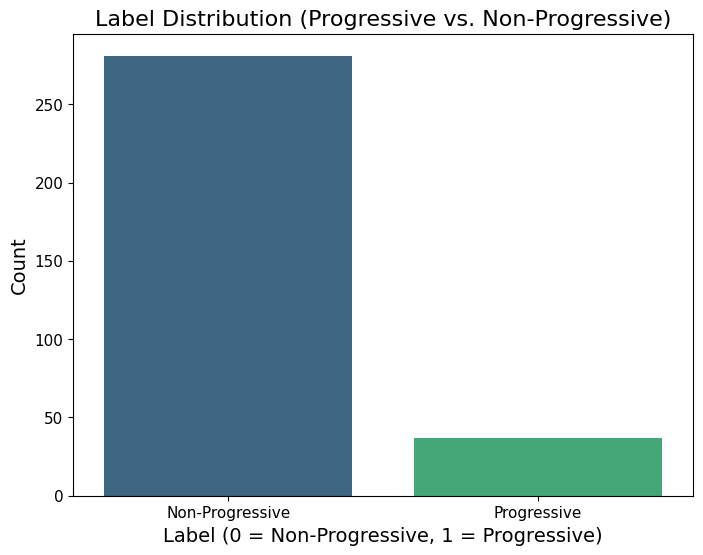

In [11]:
# Count the number of samples for each class
label_counts = df["Label"].value_counts()

# Plot the label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", legend=False)
plt.title("Label Distribution (Progressive vs. Non-Progressive)", fontsize=16)
plt.xlabel("Label (0 = Non-Progressive, 1 = Progressive)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks([0, 1], ["Non-Progressive", "Progressive"])  # Replace 0 and 1 with meaningful labels
plt.show()

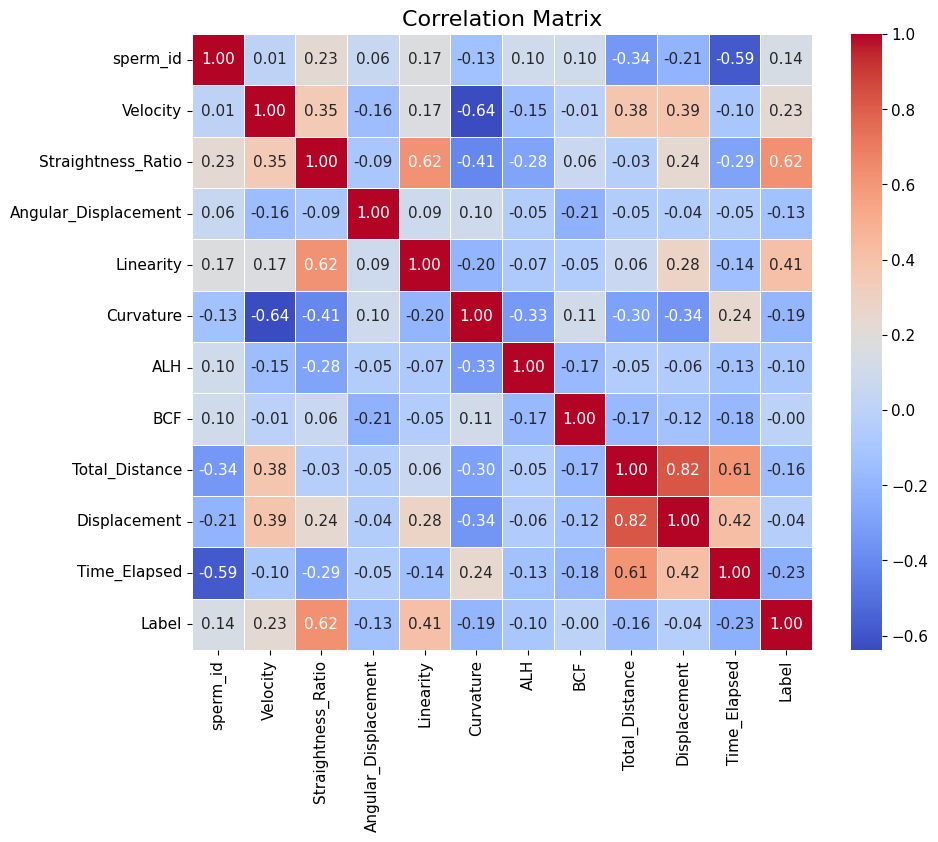

In [12]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

## Create model with data results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall

# Load the tracking data from a CSV file
df = pd.read_csv('results/data_features_labeling/dataset' + video_number + '.csv')

# Features and labels
X = df.drop(["Label","sperm_id"], axis=1).values
y = df["Label"].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the deep learning model
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.2),  # Dropout for regularization
    Dense(32, activation="relu"),  # Hidden layer
    Dropout(0.2),  # Dropout for regularization
    Dense(16, activation="relu"),  # Hidden layer
    Dense(1, activation="sigmoid")  # Output layer (binary classification)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[Accuracy(), Precision(), Recall()]
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

print(model)

# Evaluate the model on the test set
test_results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions



Epoch 1/50

13/13 [==============================] - 1s 17ms/step - loss: 0.6757 - accuracy: 0.0000e+00 - precision: 0.1667 - recall: 0.0435 - val_loss: 0.6732 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
13/13 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6510 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
13/13 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6253 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
13/13 [==============================] - 0s 3ms/step - loss: 0.5942 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5958 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
13/13 [==